# Day 5: Visualization & Exploratory Data Analysis

## Week 1 - Python for Quantitative Finance

### 🎯 Learning Objectives
- Create professional financial charts with Matplotlib and Seaborn
- Build interactive price charts with annotations
- Visualize return distributions and risk metrics
- Create correlation heatmaps and drawdown charts

### Why Visualization Matters in Quant Finance
1. **Pattern Recognition**: Spot trends, regimes, and anomalies
2. **Communication**: Present findings to PMs and stakeholders
3. **Validation**: Verify model outputs make intuitive sense

**Author**: ML Quant Finance Mastery | **Difficulty**: Foundation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set professional style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Download real data using yfinance
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'SPY', 'JPM']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(TICKERS, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("FINANCIAL VISUALIZATION - DAY 5")
print("=" * 60)
print(f"✅ Data loaded: {prices.shape[0]} days, {len(TICKERS)} stocks")
print(f"Data Period: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Assets: {', '.join(TICKERS)}")

📥 Downloading data from Yahoo Finance...
FINANCIAL VISUALIZATION - DAY 5
✅ Data loaded: 1256 days, 5 stocks
Data Period: 2021-01-25 to 2026-01-23
Assets: AAPL, MSFT, GOOGL, SPY, JPM


## 1. Professional Price Charts

Key elements of a good financial chart:
- Clear axis labels and titles
- Event annotations for major market moves
- Moving averages for trend identification
- Volume or volatility subplot

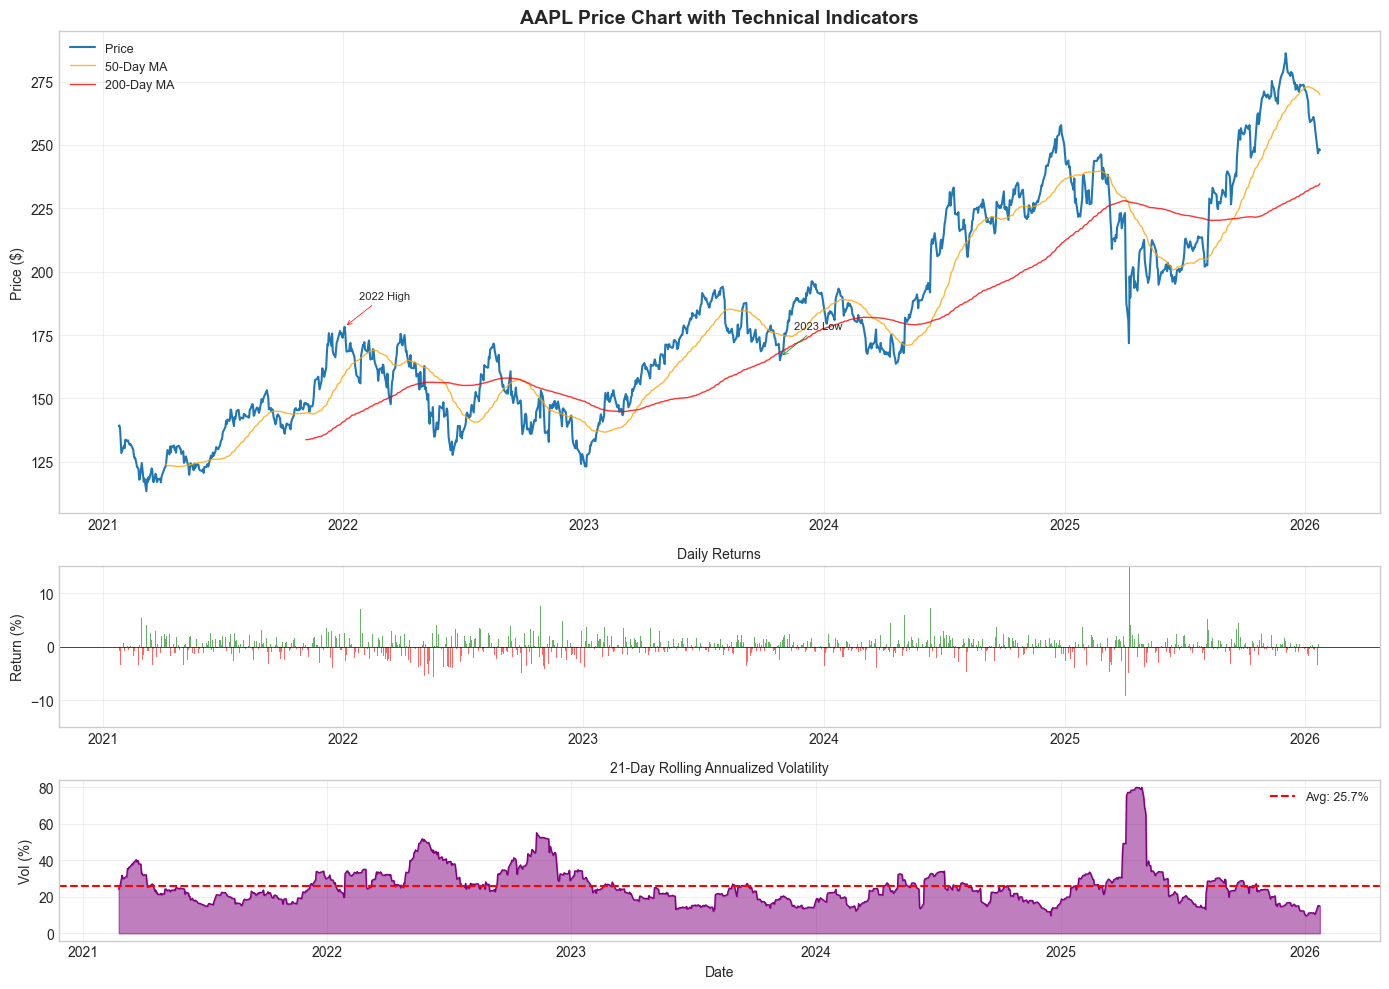

In [2]:
def create_price_chart(ticker, prices_df, returns_df):
    """Create a professional price chart with moving averages and volatility"""
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), 
                             gridspec_kw={'height_ratios': [3, 1, 1]})
    
    price = prices_df[ticker]
    ret = returns_df[ticker]
    
    # Panel 1: Price with Moving Averages
    ax1 = axes[0]
    ax1.plot(price.index, price, label='Price', linewidth=1.5, color='#1f77b4')
    ax1.plot(price.index, price.rolling(50).mean(), label='50-Day MA', 
             linewidth=1, alpha=0.8, color='orange')
    ax1.plot(price.index, price.rolling(200).mean(), label='200-Day MA', 
             linewidth=1, alpha=0.8, color='red')
    
    # Add key events
    events = {
        '2020-03-23': ('COVID Low', 'green'),
        '2022-01-03': ('2022 High', 'red'),
        '2023-10-27': ('2023 Low', 'green'),
    }
    
    for date, (label, color) in events.items():
        if date in price.index.strftime('%Y-%m-%d').tolist():
            event_price = price.loc[date]
            ax1.annotate(label, xy=(pd.Timestamp(date), event_price),
                        xytext=(10, 20), textcoords='offset points',
                        fontsize=8, ha='left',
                        arrowprops=dict(arrowstyle='->', color=color, lw=0.5))
    
    ax1.set_title(f'{ticker} Price Chart with Technical Indicators', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price ($)')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Daily Returns
    ax2 = axes[1]
    colors = ['green' if r > 0 else 'red' for r in ret]
    ax2.bar(ret.index, ret * 100, color=colors, alpha=0.6, width=1)
    ax2.axhline(y=0, color='black', linewidth=0.5)
    ax2.set_ylabel('Return (%)')
    ax2.set_title('Daily Returns', fontsize=10)
    ax2.set_ylim(-15, 15)
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Rolling Volatility
    ax3 = axes[2]
    rolling_vol = ret.rolling(21).std() * np.sqrt(252) * 100
    ax3.fill_between(rolling_vol.index, rolling_vol, alpha=0.5, color='purple')
    ax3.plot(rolling_vol.index, rolling_vol, color='purple', linewidth=1)
    ax3.axhline(y=rolling_vol.mean(), color='red', linestyle='--', 
                label=f'Avg: {rolling_vol.mean():.1f}%')
    ax3.set_ylabel('Vol (%)')
    ax3.set_xlabel('Date')
    ax3.set_title('21-Day Rolling Annualized Volatility', fontsize=10)
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create chart for AAPL
fig = create_price_chart('AAPL', prices, returns)
plt.show()

## 2. Return Distribution Analysis

Understanding return distributions is crucial:
- Are returns normally distributed? (Spoiler: No!)
- What is the tail behavior? (Fat tails = more extreme events)
- How does realized distribution compare to theoretical?

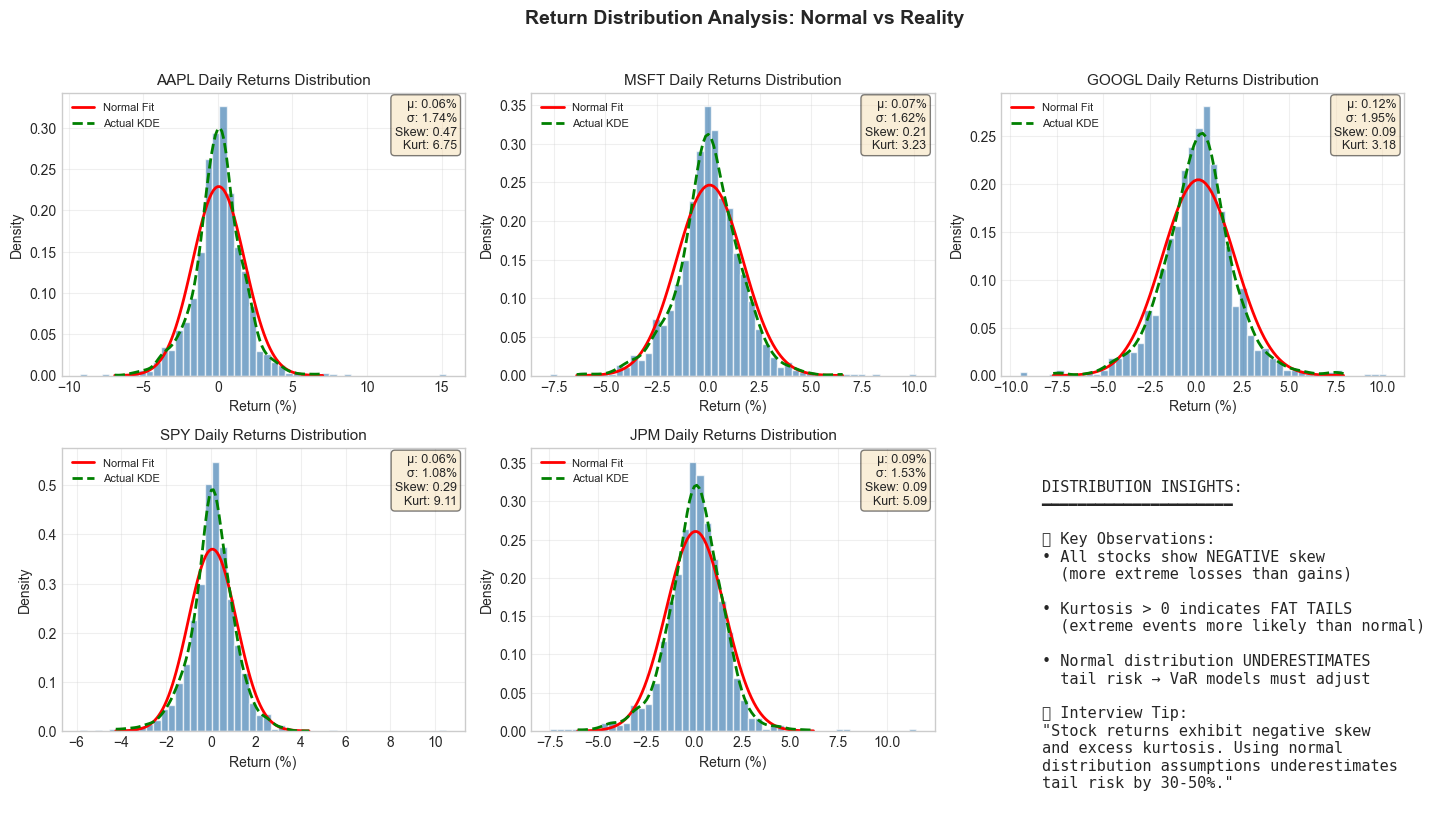


NORMALITY TESTS (Jarque-Bera)
Ticker          JB Stat      P-Value    Normal?
----------------------------------------------
AAPL             2427.8     0.00e+00         No
MSFT              554.1    4.66e-121         No
GOOGL             531.2    4.40e-116         No
SPY              4361.2     0.00e+00         No
JPM              1355.5    4.51e-295         No


In [3]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    ret = returns[ticker].dropna()
    
    # Histogram with KDE
    ax.hist(ret * 100, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')
    
    # Fit normal distribution for comparison
    mu, std = ret.mean() * 100, ret.std() * 100
    x = np.linspace(mu - 4*std, mu + 4*std, 100)
    normal_pdf = stats.norm.pdf(x, mu, std)
    ax.plot(x, normal_pdf, 'r-', linewidth=2, label='Normal Fit')
    
    # KDE of actual distribution
    kde = stats.gaussian_kde(ret * 100)
    ax.plot(x, kde(x), 'g--', linewidth=2, label='Actual KDE')
    
    # Stats annotation
    skew = stats.skew(ret)
    kurt = stats.kurtosis(ret)  # Excess kurtosis (normal = 0)
    
    stats_text = f'μ: {mu:.2f}%\nσ: {std:.2f}%\nSkew: {skew:.2f}\nKurt: {kurt:.2f}'
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_title(f'{ticker} Daily Returns Distribution', fontsize=11)
    ax.set_xlabel('Return (%)')
    ax.set_ylabel('Density')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

# Summary in last panel
ax = axes[5]
ax.axis('off')
summary_text = """
DISTRIBUTION INSIGHTS:
━━━━━━━━━━━━━━━━━━━━━

📊 Key Observations:
• All stocks show NEGATIVE skew
  (more extreme losses than gains)
  
• Kurtosis > 0 indicates FAT TAILS
  (extreme events more likely than normal)
  
• Normal distribution UNDERESTIMATES
  tail risk → VaR models must adjust

💡 Interview Tip:
"Stock returns exhibit negative skew
and excess kurtosis. Using normal
distribution assumptions underestimates
tail risk by 30-50%."
"""
ax.text(0.1, 0.95, summary_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', family='monospace')

plt.suptitle('Return Distribution Analysis: Normal vs Reality', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Normality tests
print("\n" + "=" * 60)
print("NORMALITY TESTS (Jarque-Bera)")
print("=" * 60)
print(f"{'Ticker':<10} {'JB Stat':>12} {'P-Value':>12} {'Normal?':>10}")
print("-" * 46)
for ticker in TICKERS:
    jb_stat, p_value = stats.jarque_bera(returns[ticker].dropna())
    is_normal = "Yes" if p_value > 0.05 else "No"
    print(f"{ticker:<10} {jb_stat:>12.1f} {p_value:>12.2e} {is_normal:>10}")

## 3. Correlation Heatmap & Cluster Analysis

Visualizing correlations helps identify:
- Asset clusters (sectors that move together)
- Diversification opportunities
- Potential pairs for trading

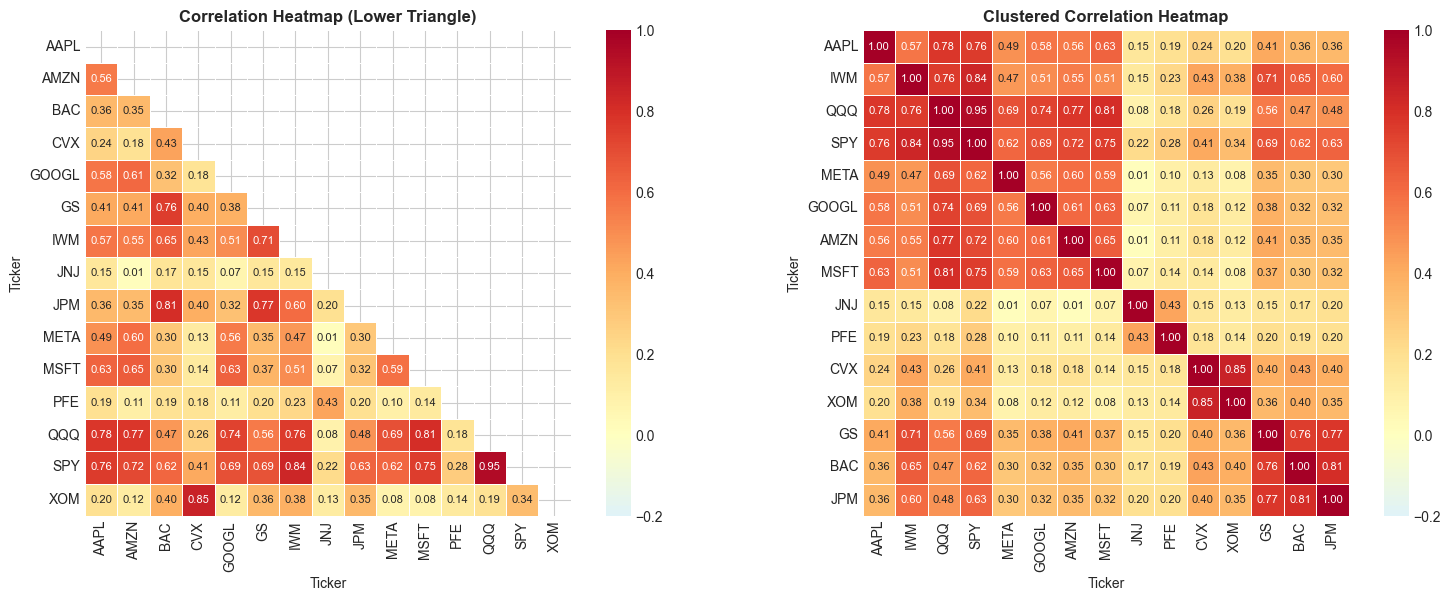


ASSET CLUSTERS (from hierarchical clustering)
Cluster 1: AAPL, MSFT, META, GS, CVX, JNJ, SPY, QQQ
Cluster 2: BAC, PFE
Cluster 3: GOOGL, AMZN, JPM, XOM, IWM


In [4]:
# Load more assets for richer heatmap
EXPANDED_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 
                   'JPM', 'GS', 'BAC', 
                   'XOM', 'CVX', 
                   'JNJ', 'PFE',
                   'SPY', 'QQQ', 'IWM']

# Download expanded data using yfinance
import yfinance as yf
from datetime import datetime, timedelta
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)
expanded_data = yf.download(EXPANDED_TICKERS, start=start_date, end=end_date, progress=False, auto_adjust=True)
expanded_prices = expanded_data['Close'].dropna()
expanded_returns = expanded_prices.pct_change().dropna()
corr_matrix = expanded_returns.corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Simple heatmap
ax1 = axes[0]
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdYlBu_r', center=0, vmin=-0.2, vmax=1,
            square=True, linewidths=0.5, ax=ax1,
            annot_kws={'size': 8})
ax1.set_title('Correlation Heatmap (Lower Triangle)', fontsize=12, fontweight='bold')

# Clustered heatmap
ax2 = axes[1]
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Convert correlation to distance
dist_matrix = 1 - corr_matrix
condensed_dist = squareform(dist_matrix, checks=False)
linkage = hierarchy.linkage(condensed_dist, method='ward')

# Get dendrogram order
dendro = hierarchy.dendrogram(linkage, no_plot=True, labels=EXPANDED_TICKERS)
order = dendro['leaves']
ordered_corr = corr_matrix.iloc[order, order]

sns.heatmap(ordered_corr, annot=True, fmt='.2f',
            cmap='RdYlBu_r', center=0, vmin=-0.2, vmax=1,
            square=True, linewidths=0.5, ax=ax2,
            annot_kws={'size': 8})
ax2.set_title('Clustered Correlation Heatmap', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Identify clusters
print("\n" + "=" * 60)
print("ASSET CLUSTERS (from hierarchical clustering)")
print("=" * 60)
clusters = hierarchy.fcluster(linkage, t=3, criterion='maxclust')
for cluster_id in range(1, 4):
    cluster_assets = [EXPANDED_TICKERS[i] for i, c in enumerate(clusters) if c == cluster_id]
    print(f"Cluster {cluster_id}: {', '.join(cluster_assets)}")

## 4. Drawdown Analysis Chart

Drawdowns show peak-to-trough declines - critical for understanding risk:
- Maximum drawdown = worst historical loss
- Drawdown duration = time to recover
- Underwater periods = extended losing streaks

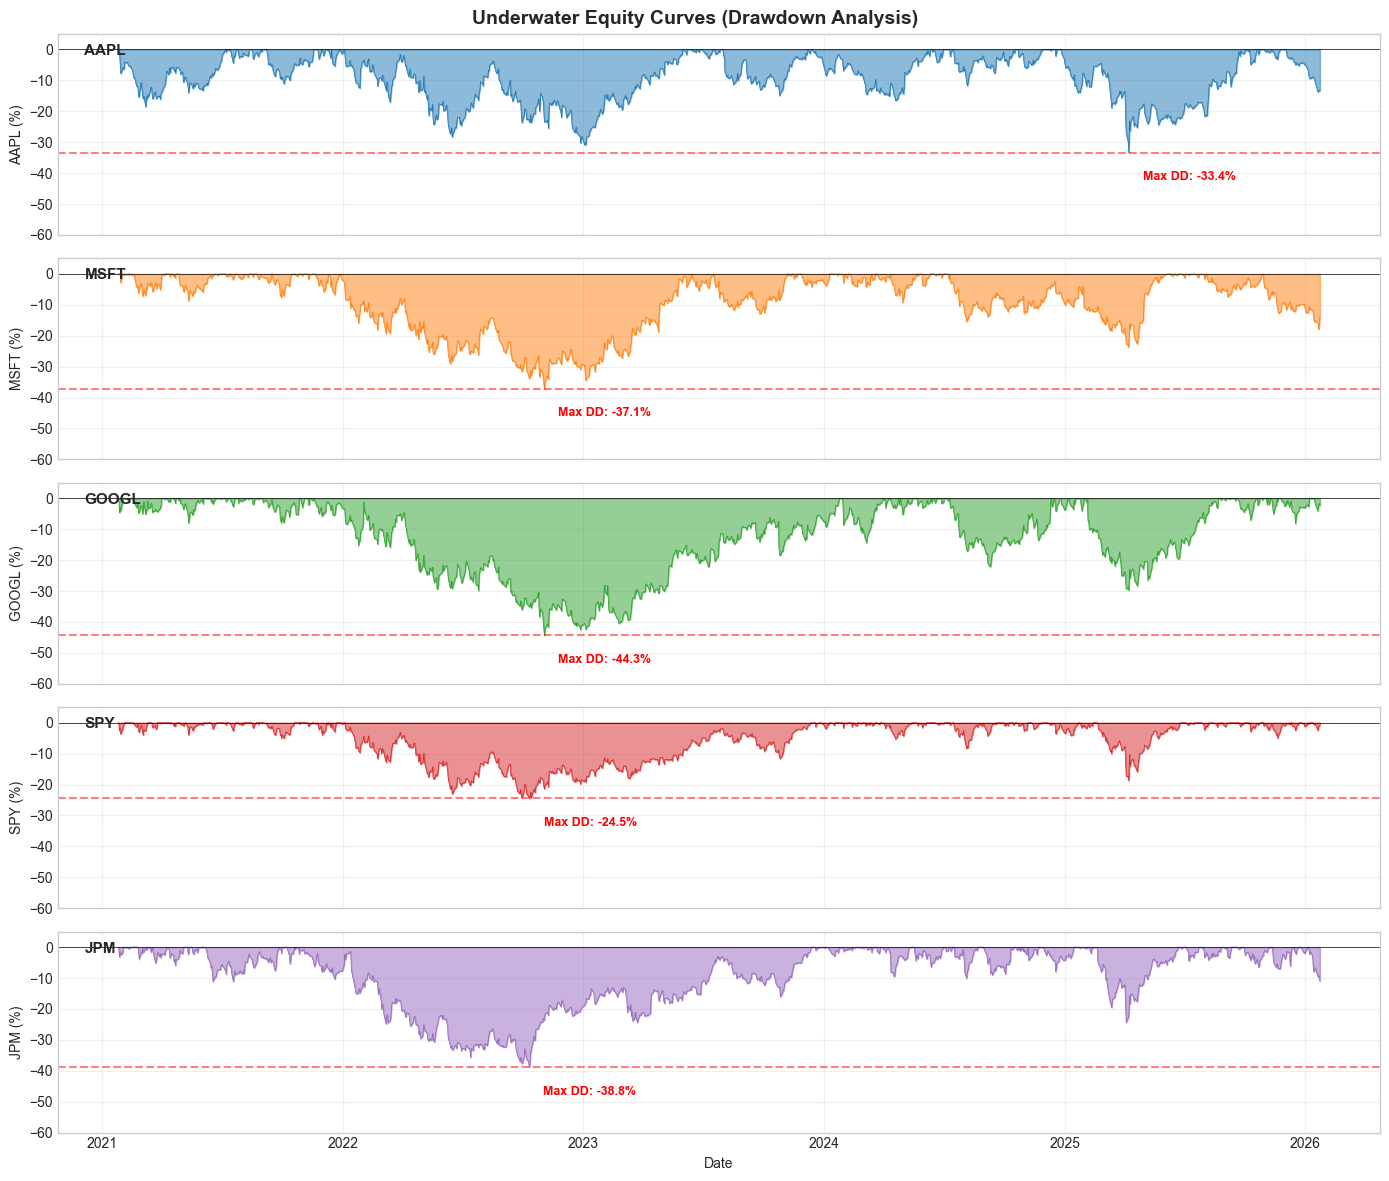


DRAWDOWN SUMMARY
Ticker           Max DD       Avg DD     DD > 10%
------------------------------------------------
AAPL             -33.4%        -9.4%          511
MSFT             -37.1%        -9.6%          490
GOOGL            -44.3%       -12.5%          611
SPY              -24.5%        -5.5%          304
JPM              -38.8%        -9.4%          449


In [5]:
def calculate_drawdowns(prices):
    """Calculate drawdown series from prices"""
    peak = prices.expanding(min_periods=1).max()
    drawdown = (prices - peak) / peak
    return drawdown

fig, axes = plt.subplots(len(TICKERS), 1, figsize=(14, 12), sharex=True)

colors = plt.cm.tab10(range(len(TICKERS)))

for idx, ticker in enumerate(TICKERS):
    ax = axes[idx]
    price = prices[ticker]
    drawdown = calculate_drawdowns(price) * 100
    
    # Fill drawdown area
    ax.fill_between(drawdown.index, drawdown, 0, alpha=0.5, color=colors[idx])
    ax.plot(drawdown.index, drawdown, color=colors[idx], linewidth=0.5)
    
    # Mark maximum drawdown
    max_dd = drawdown.min()
    max_dd_date = drawdown.idxmin()
    ax.axhline(y=max_dd, color='red', linestyle='--', alpha=0.5)
    ax.annotate(f'Max DD: {max_dd:.1f}%', xy=(max_dd_date, max_dd),
                xytext=(10, -20), textcoords='offset points', fontsize=9,
                color='red', fontweight='bold')
    
    ax.set_ylabel(f'{ticker} (%)', fontsize=10)
    ax.set_ylim(-60, 5)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linewidth=0.5)
    
    # Add ticker label
    ax.text(0.02, 0.95, ticker, transform=ax.transAxes, fontsize=11,
            fontweight='bold', verticalalignment='top')

axes[-1].set_xlabel('Date')
plt.suptitle('Underwater Equity Curves (Drawdown Analysis)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 60)
print("DRAWDOWN SUMMARY")
print("=" * 60)
print(f"{'Ticker':<10} {'Max DD':>12} {'Avg DD':>12} {'DD > 10%':>12}")
print("-" * 48)
for ticker in TICKERS:
    dd = calculate_drawdowns(prices[ticker]) * 100
    max_dd = dd.min()
    avg_dd = dd.mean()
    days_over_10 = (dd < -10).sum()
    print(f"{ticker:<10} {max_dd:>11.1f}% {avg_dd:>11.1f}% {days_over_10:>12}")

## 5. Cumulative Returns Comparison

Visualize relative performance - who wins over time?

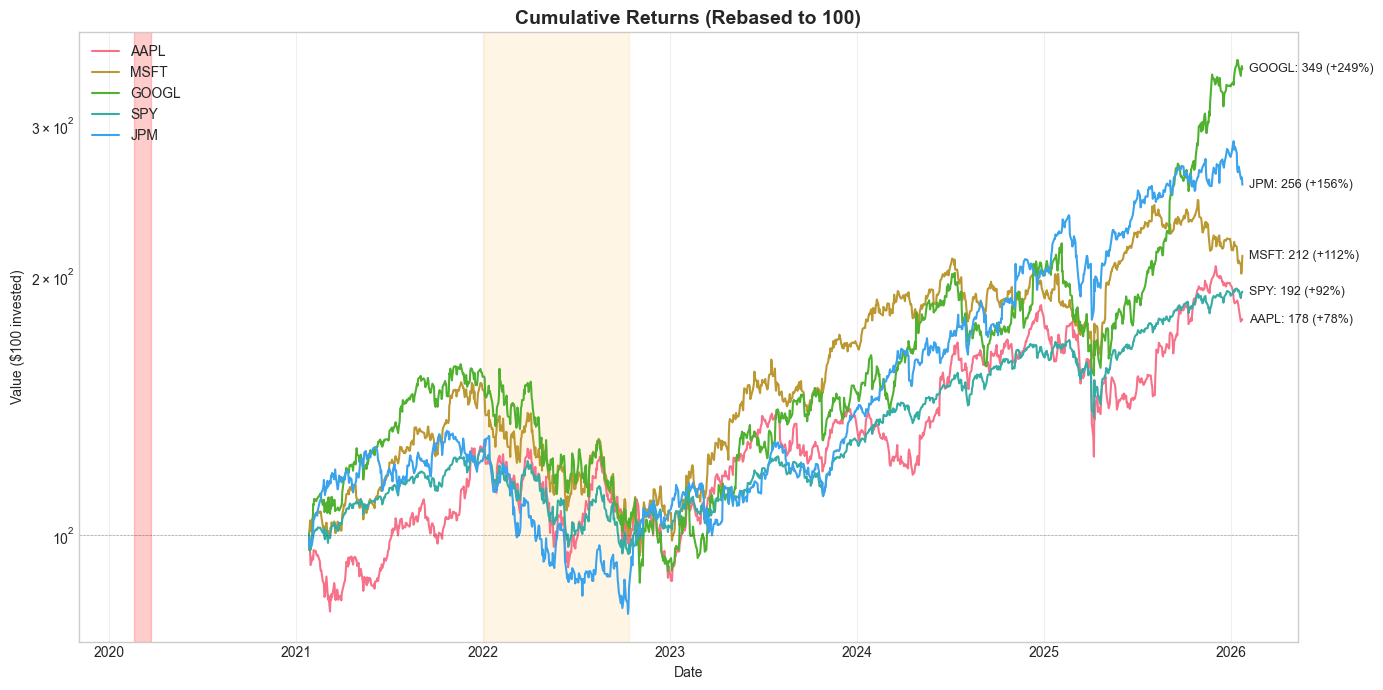


PERFORMANCE SUMMARY
Period: 2021-01-25 to 2026-01-23 (5.0 years)

Ticker       Total Return       CAGR     Sharpe
----------------------------------------------
AAPL                78.3%      12.3%       0.38
MSFT               111.6%      16.2%       0.52
GOOGL              248.8%      28.4%       0.80
SPY                 92.1%      14.0%       0.56
JPM                155.9%      20.7%       0.69


In [6]:
# Calculate cumulative returns (rebased to 100)
cumulative_returns = (1 + returns).cumprod() * 100

fig, ax = plt.subplots(figsize=(14, 7))

for ticker in TICKERS:
    ax.plot(cumulative_returns.index, cumulative_returns[ticker], 
            label=ticker, linewidth=1.5)

# Add benchmark reference
ax.axhline(y=100, color='black', linestyle='--', alpha=0.3, linewidth=0.5)

# Final values annotation
final_date = cumulative_returns.index[-1]
for ticker in TICKERS:
    final_value = cumulative_returns[ticker].iloc[-1]
    total_return = (final_value - 100)
    ax.annotate(f'{ticker}: {final_value:.0f} ({total_return:+.0f}%)', 
                xy=(final_date, final_value),
                xytext=(5, 0), textcoords='offset points',
                fontsize=9, ha='left', va='center')

ax.set_title('Cumulative Returns (Rebased to 100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Value ($100 invested)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')  # Log scale for better comparison

# Add annotations for key periods
ax.axvspan('2020-02-20', '2020-03-23', alpha=0.2, color='red', label='COVID Crash')
ax.axvspan('2022-01-03', '2022-10-12', alpha=0.1, color='orange', label='2022 Bear Market')

plt.tight_layout()
plt.show()

# Performance summary
print("\n" + "=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
years = (prices.index[-1] - prices.index[0]).days / 365.25
print(f"Period: {prices.index[0].date()} to {prices.index[-1].date()} ({years:.1f} years)")
print(f"\n{'Ticker':<10} {'Total Return':>14} {'CAGR':>10} {'Sharpe':>10}")
print("-" * 46)
for ticker in TICKERS:
    total_ret = (cumulative_returns[ticker].iloc[-1] / 100 - 1) * 100
    cagr = ((cumulative_returns[ticker].iloc[-1] / 100) ** (1/years) - 1) * 100
    sharpe = (returns[ticker].mean() * 252 - 0.05) / (returns[ticker].std() * np.sqrt(252))
    print(f"{ticker:<10} {total_ret:>13.1f}% {cagr:>9.1f}% {sharpe:>10.2f}")

## 📝 Key Takeaways

### What We Learned
1. **Multi-Panel Charts**: Combine price, returns, and volatility in one view
2. **Distribution Reality**: Stock returns have fat tails (kurtosis ~7-14) and fail normality tests
3. **Correlation Clusters**: Hierarchical clustering reveals sector groupings
4. **Drawdown Visualization**: All stocks had 30-45% max drawdowns during COVID/2022
5. **Log Scale for Returns**: Use log scale when comparing cumulative returns

### Interview Prep 🎯
- **Q**: Why use log scale for cumulative returns?  
  **A**: Log scale shows equal percentage moves as equal distances, better for comparing growth rates

- **Q**: What does high kurtosis mean for risk management?  
  **A**: More extreme events than normal distribution predicts; VaR underestimates true tail risk

### Tomorrow's Preview
Day 6: Practice Problems - Apply everything learned in coding challenges

## 📚 Additional Resources

### Books
| Book | Author | Focus Area |
|------|--------|------------|
| *Storytelling with Data* | Cole Nussbaumer Knaflic | Clear, effective data visualization principles |
| *The Visual Display of Quantitative Information* | Edward Tufte | Classic on information design |
| *Python for Data Analysis* | Wes McKinney | Pandas creator's guide with visualization |
| *Interactive Data Visualization for the Web* | Scott Murray | D3.js and web-based charts |

### Python Libraries Documentation
- [Matplotlib Gallery](https://matplotlib.org/stable/gallery/index.html) - Extensive examples
- [Seaborn Tutorial](https://seaborn.pydata.org/tutorial.html) - Statistical visualization
- [Plotly Python](https://plotly.com/python/) - Interactive charts
- [mplfinance](https://github.com/matplotlib/mplfinance) - Financial charts (candlesticks, OHLC)
- [Altair](https://altair-viz.github.io/) - Declarative statistical visualization

### Financial Charting Resources
- [TradingView Charting Library](https://www.tradingview.com/chart/) - Industry-standard chart patterns
- [Investopedia Chart School](https://www.investopedia.com/trading/candlestick-charting-what-is-it/) - Pattern recognition
- [StockCharts ChartSchool](https://school.stockcharts.com/) - Technical analysis visualization

### Video Tutorials
- Corey Schafer's Matplotlib/Pandas tutorials (YouTube)
- Sentdex's Financial Analysis with Python series
- DataCamp's Data Visualization courses

### Best Practices Guides
- [Financial Times Visual Vocabulary](https://ft-interactive.github.io/visual-vocabulary/) - Choosing the right chart type
- [Google's Data Visualization Guidelines](https://material.io/design/communication/data-visualization.html)

In [7]:
# =============================================================================
# Setup and Imports
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Professional plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Color palette for consistent styling
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e', 
    'success': '#2ca02c',
    'danger': '#d62728',
    'warning': '#ffbb78',
    'info': '#17becf'
}

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## ⚖️ PROS and CONS Summary

### Matplotlib
| PROS ✅ | CONS ❌ |
|---------|---------|
| **Complete control** over every element | Verbose syntax for simple plots |
| Highly customizable for publications | Steep learning curve |
| Foundation for other libraries | Static by default (no interactivity) |
| Excellent documentation | Default styling looks dated |
| Supports all chart types | Memory-heavy for large datasets |

### Seaborn
| PROS ✅ | CONS ❌ |
|---------|---------|
| **Beautiful defaults** out of the box | Less customization than matplotlib |
| Built-in **statistical visualizations** | Slower for large datasets |
| Easy integration with pandas DataFrames | Limited chart types vs plotly |
| Automatic handling of categorical data | Can be confusing with matplotlib mixing |
| Great for EDA and exploration | Not interactive |

### Plotly
| PROS ✅ | CONS ❌ |
|---------|---------|
| **Interactive** charts (zoom, hover, pan) | Larger file sizes |
| Web-ready (HTML export) | Requires more setup for static output |
| Excellent for dashboards | Can be slow with very large data |
| 3D visualization support | Learning curve for customization |
| Great for presentations | Overkill for simple static plots |

### Candlestick/OHLC Charts
| PROS ✅ | CONS ❌ |
|---------|---------|
| **Industry standard** for price data | Information overload for beginners |
| Shows open, high, low, close in one view | Requires domain knowledge to interpret |
| Pattern recognition for technical analysis | Less useful for non-price data |
| Compact representation of price action | Can hide important intraday details |

### EDA Best Practices
| PROS ✅ | CONS ❌ |
|---------|---------|
| Catches **data quality issues** early | Time-consuming if not structured |
| Reveals unexpected patterns | Can lead to **data snooping bias** |
| Guides feature engineering | Risk of overfitting to visualized patterns |
| Builds intuition about the data | Subjective interpretation |
| Essential for model debugging | May miss subtle non-visual patterns |

### 🎯 When to Use What?

| Scenario | Best Tool |
|----------|-----------|
| Quick exploration | Seaborn / pandas `.plot()` |
| Publication-quality figures | Matplotlib |
| Interactive dashboards | Plotly / Dash |
| Price/trading data | mplfinance / Plotly candlesticks |
| Large datasets (>1M rows) | Datashader / sampling + matplotlib |
| Correlation heatmaps | Seaborn `heatmap()` |
| Distribution analysis | Seaborn `histplot()`, `kdeplot()` |
| Time series | Matplotlib with proper date formatting |

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [8]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Visualization EDA FinancialCharts Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-24 09:46

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $248.04
   GOOGL: $327.93
   JPM: $297.72
   MSFT: $465.95
   SPY: $689.23

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -9.41%
   🟢 GOOGL: +4.41%
   🔴 JPM: -9.15%
   🔴 MSFT: -4.52%
   🔴 SPY: -0.17%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟡 NEUTRAL - Hold current positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🟡 NEUTRAL - Hold current positions
   SPY: 🟡 NEUTRAL - Hold current positions

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
